# Prepapring Textual Data

```{note}
Install ekorpkit package fist.
Set logging level to Warning, if you don't want to see vervose logging,
```

In [1]:
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.INFO)
print(eKonf.__version__)

0.1.31+8.gdef1e03.dirty


In [2]:
data_dir = "../data/fomc"
save_dataframe = eKonf.partial(
    config_group="_func_/save_dataframe", output_dir=data_dir
)
load_dataframe = eKonf.partial(config_group="_func_/load_dataframe", data_dir=data_dir)

INFO:ekorpkit.ekonf:initialized batcher with <ekorpkit.utils.batch.batcher.Batcher object at 0x7f70cfe9ba90>


## Load FOMC corpus

In [3]:
cfg = eKonf.compose(config_group='corpus')
cfg.name = 'fomc'
cfg.cache.uri = 'https://github.com/entelecheia/ekorpkit-config/raw/main/data/fomc.zip'
cfg.data_dir = cfg.cache.path
cfg.automerge = True
fomc_corpus = eKonf.instantiate(cfg)
print(fomc_corpus)

INFO:cached_path:cache of https://github.com/entelecheia/ekorpkit-config/raw/main/data/fomc.zip is up-to-date
INFO:ekorpkit.io.cached_path:cached path: /workspace/.cache/cached_path/934fce31ba4df4fe3b1f2226f59e13f8073b9813717037a5e836a9898c124bc7.14993cbcce092b4473939a6ed9e8246dfeb3d500c53c11c6279991e9a0eba476-extracted
INFO:cached_path:cache of https://github.com/entelecheia/ekorpkit-config/raw/main/data/fomc.zip is up-to-date
INFO:ekorpkit.io.cached_path:cached path: /workspace/.cache/cached_path/934fce31ba4df4fe3b1f2226f59e13f8073b9813717037a5e836a9898c124bc7.14993cbcce092b4473939a6ed9e8246dfeb3d500c53c11c6279991e9a0eba476-extracted
INFO:ekorpkit.io.file:Processing [1] files from [['fomc-train.parquet']]
INFO:ekorpkit.io.file:Loading data from /workspace/.cache/cached_path/934fce31ba4df4fe3b1f2226f59e13f8073b9813717037a5e836a9898c124bc7.14993cbcce092b4473939a6ed9e8246dfeb3d500c53c11c6279991e9a0eba476-extracted/fomc/fomc-train.parquet
INFO:ekorpkit.io.file:Processing [1] files from [

Corpus : fomc


## Load FOMC class

In [4]:
cfg = eKonf.compose(config_group="io/fetcher/fomc")
cfg.output_dir = "../data/fomc"
fomc = eKonf.instantiate(cfg)

INFO:ekorpkit.io.fetch.fomc.base:Initializing fomc_base


In [5]:
fomc.load_calendar(from_year=1982, force_download=False)

INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_calendar.parquet


,unscheduled,forecast,confcall,speaker,rate,rate_change,rate_decision,rate_changed
date,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.50,-0.50,-1.0,1
1982-11-16,False,False,False,Paul Volcker,9.00,-0.50,-1.0,1
1982-12-21,False,False,False,Paul Volcker,8.50,0.00,0.0,0
1983-01-14,False,False,True,Paul Volcker,8.50,0.00,0.0,0
1983-01-21,False,False,True,Paul Volcker,8.50,0.00,0.0,0
...,...,...,...,...,...,...,...,...
2021-11-03,False,False,False,Jerome Powell,0.25,0.00,0.0,0
2021-12-15,False,True,False,Jerome Powell,0.25,0.00,0.0,0
2022-01-26,False,False,False,Jerome Powell,0.25,0.00,0.0,0


## Postprocess metadata

In [6]:
# Postprocessing
fomc_data = fomc.postprocess_metadata(fomc_corpus.data)
fomc_data.tail()

,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-10-29,2.0,0.25
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-12-17,0.0,0.25
2821,2854,"CHAIR YELLEN. Good afternoon, everyone. I th...",2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25


## Distribution of number of words in FOMC corpus

In [7]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
overrides=[
    '+pipeline=default',
    'pipeline/filter_length=words',
]
cfg = eKonf.compose(config_group="pipeline", overrides=overrides)
cfg._pipeline_ = ["filter_length", "save_dataframe"]
cfg.num_workers = 4
cfg.filter_length.min_length = 50
cfg.save_dataframe.output_dir = "../data/fomc"
cfg.save_dataframe.output_file = "fomc_corpus.parquet"
fomc_data = eKonf.instantiate(cfg, data=fomc_data)
fomc_data.tail()

INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('filter_length', 'filter_length'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function filter_length at 0x7f70c616fa60>, len_bytes={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_bytes'}, len_words={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_words'})


Calculating length:   0%|          | 0/2822 [00:00<?, ?it/s]

INFO:ekorpkit.pipelines.pipe:removed 20 of 2822 documents with length < 50
INFO:ekorpkit.pipelines.pipe: >> elapsed time to filter length: 0:00:01.004116
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function save_dataframe at 0x7f70c60e83a0>)
INFO:ekorpkit.io.file:Saving dataframe as ../data/fomc/fomc_corpus.parquet


,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25,86489
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25,88197
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-10-29,2.0,0.25,61211
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-12-17,0.0,0.25,72240
2821,2854,"CHAIR YELLEN. Good afternoon, everyone. I th...",2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,58709


In [8]:
cfg = eKonf.compose(config_group="pipeline")
cfg.data_dir = "../data/fomc"
cfg.data_file = "fomc_corpus.parquet"
fomc_data = eKonf.instantiate(cfg)
fomc_data.tail()


INFO:ekorpkit.ekonf:Executing function functools.partial(<function load_dataframe at 0x7f6f3b9fdee0>) with parms {'filepath': '../data/fomc/fomc_corpus.parquet', 'columns': None, 'verbose': False}
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_corpus.parquet
INFO:ekorpkit.ekonf:Skipping execute of functools.partial(<function concat_dataframes at 0x7f6f3b9fdd30>)


,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words
2817,2850,CHAIR YELLEN. I’d like to begin by welcoming...,2014-06-18,fomc_meeting_script,2014-06-18,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-07-30,0.0,0.25,86489
2818,2851,"CHAIR YELLEN. Good morning, everybody. I wou...",2014-07-30,fomc_meeting_script,2014-07-30,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-09-17,0.0,0.25,88197
2819,2852,"CHAIR YELLEN. Good morning, everybody. Our fi...",2014-09-17,fomc_meeting_script,2014-09-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2014-10-29,2.0,0.25,61211
2820,2853,CHAIR YELLEN. I’d like to call this meeting t...,2014-10-29,fomc_meeting_script,2014-10-29,Janet Yellen,FOMC Meeting Transcript,2.0,0.25,2014-12-17,0.0,0.25,72240
2821,2854,"CHAIR YELLEN. Good afternoon, everyone. I th...",2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,58709


### Ditribution of corpus

INFO:ekorpkit.visualize.plot:Saved figure to ./figs/distplot.png


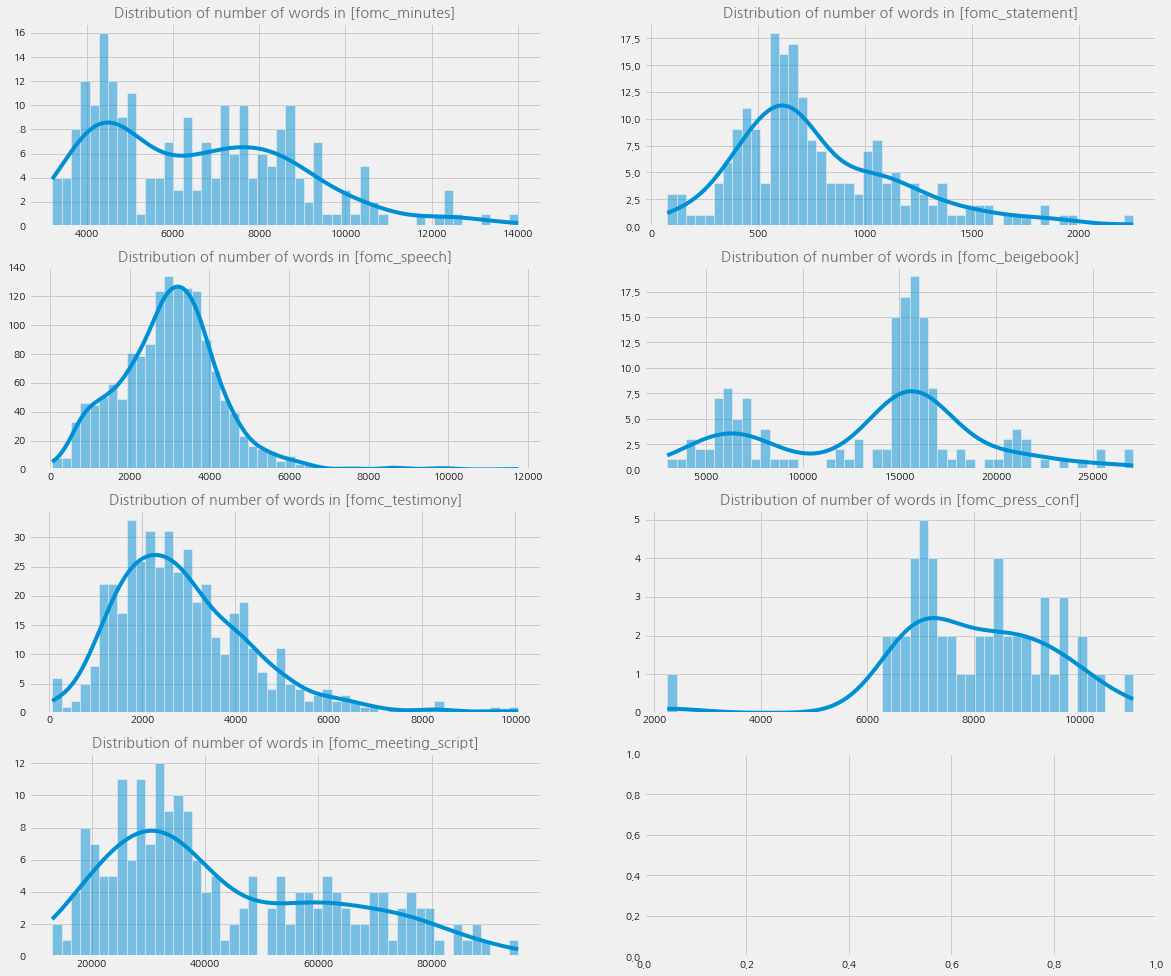

In [9]:
content_types = fomc_data.content_type.unique()

cfg = eKonf.compose(config_group="visualize/plot=histplot")
cfg.series.form = "individual"
cfg.plot.figsize = (18, 16)
cfg.plot.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
figure = cfg.figure.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.figures = [figure.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    fig = cfg.figures[i]
    fig.title =  f"Distribution of number of words in [{ctype}]"
    fig.axno = i

eKonf.instantiate(cfg, data=fomc_data)


### Split corpus into sections

In [10]:
cfg = eKonf.compose(config_group="pipeline")
cfg._pipeline_ = ["explode_splits", "filter_length", "reset_index", "save_dataframe"]
cfg.num_workers = 100
cfg.explode_splits.id_key = "id"
cfg.explode_splits.split_key = "section_id"
cfg.explode_splits.separator = "\n\n"
cfg.filter_length.min_length = 50
cfg.filter_length.len_func = "len_words"
cfg.filter_length.len_column = "num_words"
cfg.reset_index.drop_index = True
cfg.save_dataframe.output_dir = "../data/fomc"
cfg.save_dataframe.output_file = "fomc_sections.parquet"
fomc_sections = eKonf.instantiate(cfg, data=fomc_data)
fomc_sections.tail()

INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('explode_splits', 'explode_splits'), ('filter_length', 'filter_length'), ('reset_index', 'reset_index'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function explode_splits at 0x7f70c616f940>)
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function filter_length at 0x7f70c616fa60>, len_bytes={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_bytes'}, len_words={'_partial_': True, '_target_': 'ekorpkit.utils.func.len_words'})


Calculating length:   0%|          | 0/212170 [00:00<?, ?it/s]

INFO:ekorpkit.pipelines.pipe:removed 120119 of 212170 documents with length < 50
INFO:ekorpkit.pipelines.pipe: >> elapsed time to filter length: 0:00:01.383107
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function reset_index at 0x7f70c616f8b0>)
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function save_dataframe at 0x7f70c60e83a0>)
INFO:ekorpkit.io.file:Saving dataframe as ../data/fomc/fomc_sections.parquet


,id,text,timestamp,content_type,date,speaker,title,decision,rate,next_meeting,next_decision,next_rate,text_num_words,section_id
92046,2854,"MS. BRAINARD. Thank you. Since we last met, ...",2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,506,281
92047,2854,VICE CHAIRMAN DUDLEY. No worries. It happene...,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,1446,285
92048,2854,CHAIR YELLEN. Thank you. Okay. I think the ...,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,83,286
92049,2854,"MR. LUECKE. This vote, as Chair Yellen indica...",2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,73,287
92050,2854,CHAIR YELLEN. Okay. Thank you very much. An...,2014-12-17,fomc_meeting_script,2014-12-17,Janet Yellen,FOMC Meeting Transcript,0.0,0.25,2015-01-28,0.0,0.25,77,288


### Ditribution of sectons

INFO:ekorpkit.visualize.plot:Saved figure to ./figs/distplot.png


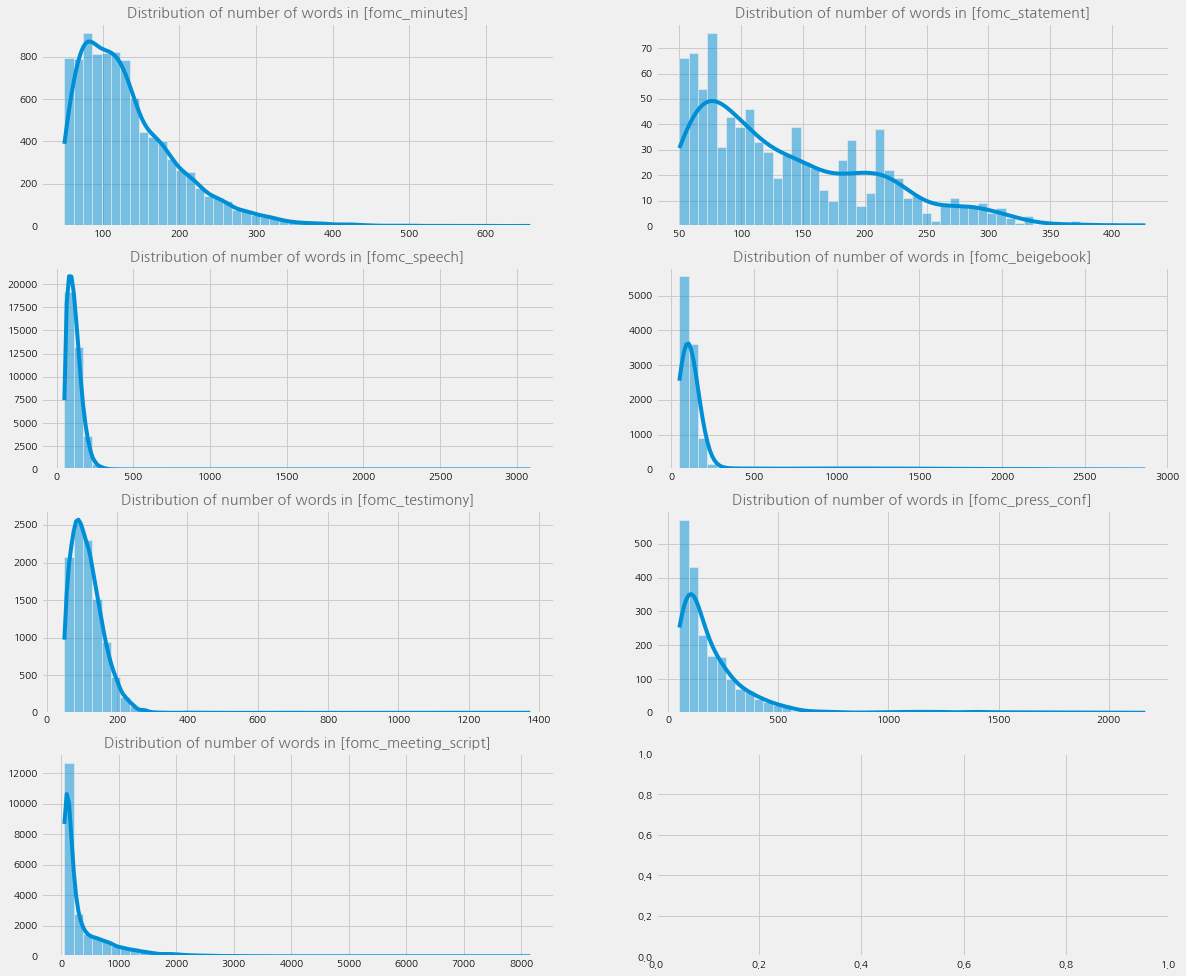

In [11]:
cfg = eKonf.compose(config_group="visualize/plot=histplot")
cfg.series.form = "individual"
cfg.plot.figsize = (18, 16)
cfg.plot.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
figure = cfg.figure.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.figures = [figure.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    fig = cfg.figures[i]
    fig.title =  f"Distribution of number of words in [{ctype}]"
    fig.axno = i

eKonf.instantiate(cfg, data=fomc_sections)

### Split sections into chunks

In [12]:
seg_cfg = eKonf.compose(config_group="preprocessor/segmenter=pysbd")

cfg = eKonf.compose(config_group="pipeline")
cfg.data_dir = "../data/fomc"
cfg.data_file = "fomc_sections.parquet"
cfg._pipeline_ = [
    "segment",
    "chunk",
    "explode_splits",
    "filter_length",
    "reset_index",
    "save_dataframe",
]
cfg.segment.preprocessor.segmenter = seg_cfg
cfg.num_workers = 100
cfg.chunk.chunk_size = 200
cfg.chunk.len_func = "len_words"
cfg.explode_splits.id_key = ["id", "section_id"]
cfg.explode_splits.split_key = "chunk_id"
cfg.explode_splits.separator = "\n\n"
cfg.filter_length.min_length = 50
cfg.filter_length.max_length = 350
cfg.filter_length.len_func = "len_words"
cfg.filter_length.len_column = "num_words"
cfg.reset_index.drop_index = True
cfg.save_dataframe.output_dir = "../data/fomc"
cfg.save_dataframe.output_file = "fomc_chunks.parquet"
fomc_chunks = eKonf.instantiate(cfg)
fomc_chunks.tail()

INFO:ekorpkit.ekonf:Executing function functools.partial(<function load_dataframe at 0x7f6f3b9fdee0>) with parms {'filepath': '../data/fomc/fomc_sections.parquet', 'columns': None, 'verbose': False}
INFO:ekorpkit.io.file:Loading data from ../data/fomc/fomc_sections.parquet
INFO:ekorpkit.ekonf:Skipping execute of functools.partial(<function concat_dataframes at 0x7f6f3b9fdd30>)
INFO:ekorpkit.pipelines.pipe:Applying pipeline: OrderedDict([('segment', 'segment'), ('chunk', 'chunk'), ('explode_splits', 'explode_splits'), ('filter_length', 'filter_length'), ('reset_index', 'reset_index'), ('save_dataframe', 'save_dataframe')])
INFO:ekorpkit.ekonf:Applying pipe: functools.partial(<function segment at 0x7f70c616f9d0>)
INFO:ekorpkit.pipelines.pipe:instantiating segmenter
INFO:ekorpkit.pipelines.pipe:Using batcher with minibatch size: 921
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 921  procs: 100  input_split: False  merge_output: True  len(data): 92051 len(args): 5
Spl

### Distribution of chunks

INFO:ekorpkit.visualize.plot:Saved figure to ./figs/distplot.png


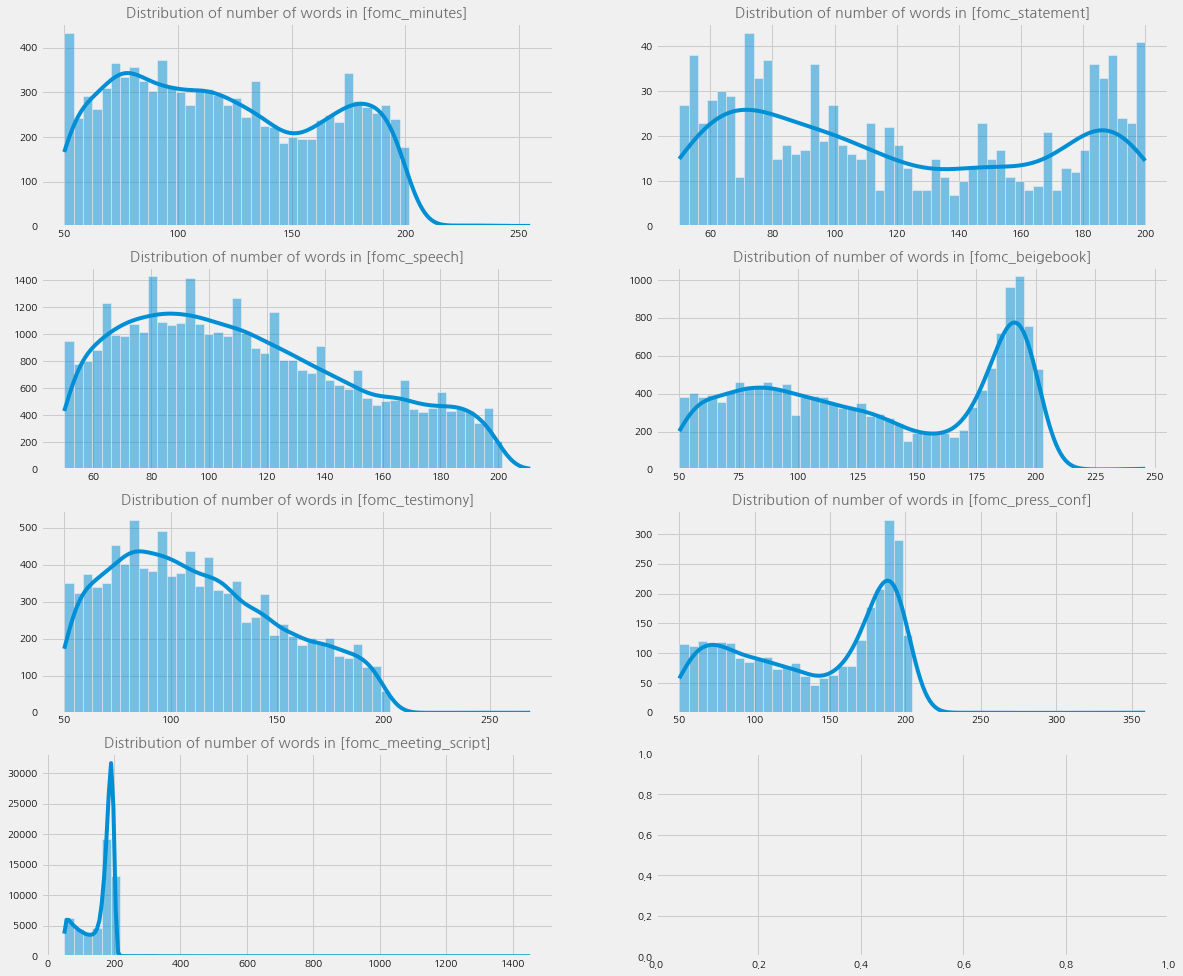

In [ ]:
content_types = fomc_chunks.content_type.unique()

cfg = eKonf.compose(config_group="visualize/plot=histplot")
cfg.series.form = "individual"
cfg.plot.figsize = (18, 16)
cfg.plot.fontsize = 10
cfg.subplots.ncols = 2
cfg.subplots.nrows = 4
figure = cfg.figure.copy()
histplot = cfg.histplot.copy()
histplot.x = "text_num_words"
histplot.bins = 50
histplot.kde = True
cfg.plots = [histplot.copy() for _ in range(len(content_types))]
cfg.figures = [figure.copy() for _ in range(len(content_types))]
for i, ctype in enumerate(content_types):
    plot = cfg.plots[i]
    plot.query = f"content_type == '{ctype}'"
    plot.axno = i
    fig = cfg.figures[i]
    fig.title =  f"Distribution of number of words in [{ctype}]"
    fig.axno = i

eKonf.instantiate(cfg, data=fomc_chunks)